In [3]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import tetrion.plots as plots
import tetrion.db
import tetrion.commands as cmd
import tetrion.options
import tetrion.clientcore
import seaborn as sns
from collections import defaultdict
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
%matplotlib inline 
symbol = pd.read_csv('/local/dist/tetrion/conf/conf/symbol.table', skiprows= 1, header = 2,  delim_whitespace=True)
pd.set_option('display.max_rows', 100)
import datetime as dt

In [4]:
df = pd.read_pickle('../data/vix_1min_2025.pkl')


In [5]:
df = df.sort_values("time").reset_index(drop=True)


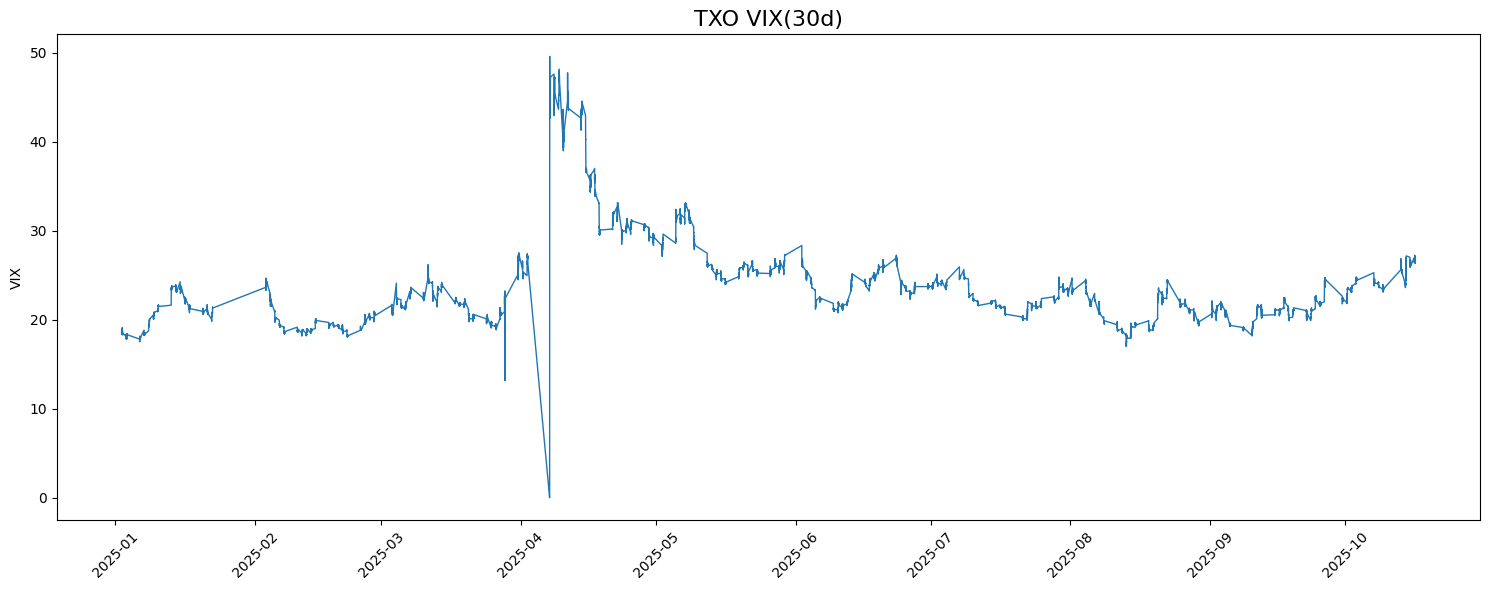

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import NullLocator   

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df["time"], df["vix_like"], lw=1)

ax.set_title("TXO VIX(30d)", fontsize=16)
ax.set_ylabel("VIX")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.xaxis.set_minor_locator(NullLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
df

time   vix_like
0     2025-01-02 08:45:00  18.475369
1     2025-01-02 08:46:00  18.423384
2     2025-01-02 08:47:00  18.465699
3     2025-01-02 08:48:00  18.465165
4     2025-01-02 08:49:00  18.559432
...                   ...        ...
56264 2025-10-16 13:41:00  26.446414
56265 2025-10-16 13:42:00  26.486857
56266 2025-10-16 13:43:00  26.602849
56267 2025-10-16 13:44:00  26.598702
56268 2025-10-16 13:45:00  26.582954

[56269 rows x 2 columns]

In [8]:
df2 = pd.read_pickle('../data/TXF_H2.pkl')

In [9]:
df2

mkt_mid               contract
time                                               
2025-05-02 09:00:00  20540.0  FUT_TAIFEX_TXF:202505
2025-05-02 09:01:00  20517.5  FUT_TAIFEX_TXF:202505
2025-05-02 09:02:00  20503.0  FUT_TAIFEX_TXF:202505
2025-05-02 09:03:00  20517.0  FUT_TAIFEX_TXF:202505
2025-05-02 09:04:00  20511.5  FUT_TAIFEX_TXF:202505
...                      ...                    ...
2025-09-19 13:40:00  25697.0  FUT_TAIFEX_TXF:202510
2025-09-19 13:41:00  25687.5  FUT_TAIFEX_TXF:202510
2025-09-19 13:42:00  25684.0  FUT_TAIFEX_TXF:202510
2025-09-19 13:43:00  25677.5  FUT_TAIFEX_TXF:202510
2025-09-19 13:44:00  25672.5  FUT_TAIFEX_TXF:202510

[24737 rows x 2 columns]

In [10]:

import plotly.express as px

df2_reset = df2.reset_index()

fig = px.line(df2_reset, x='time', y='mkt_mid', title='TXF H2 mkt_mid Trend')
fig.show()


In [11]:

import plotly.graph_objects as go

fig = go.Figure()

# Add VIX trace
fig.add_trace(go.Scatter(x=df['time'], y=df['vix_like'], mode='lines', name='VIX', yaxis='y1'))

# Add TXF mkt_mid trace with secondary y-axis
df2_reset = df2.reset_index()
fig.add_trace(go.Scatter(x=df2_reset['time'], y=df2_reset['mkt_mid'], mode='lines', name='TXF mkt_mid', yaxis='y2'))

# Update layout for dual y-axes
fig.update_layout(
    title='VIX vs TXF mkt_mid Comparison',
    xaxis=dict(title='Time'),
    yaxis=dict(title='VIX'),
    yaxis2=dict(title='mkt_mid', overlaying='y', side='right')
)

fig.show()


In [38]:
def run_gamma_scalping(price_df, gamma=10, threshold=10, cost_per_trade=0):
    """
    Simple Gamma Scalping Backtest
    """
    # Sort by time
    data = price_df.sort_values('time').reset_index(drop=True)
    
    trades = []
    last_hedge_price = data['mkt_mid'].iloc[0]
    cumulative_pnl = 0
    
    for row in data.itertuples():
        current_price = row.mkt_mid
        current_time = row.time
        
        # ds: price change since last hedge
        ds = current_price - last_hedge_price
        
        # Check threshold
        if abs(ds) >= threshold:
            # Gamma PnL (Gross) = 0.5 * Gamma * ds^2
            gross_pnl = 0.5 * gamma * (ds ** 2)
            
            # Calculate cost
            # Trade volume = Gamma * ds
            trade_vol = abs(gamma * ds)
            cost = trade_vol * cost_per_trade
            
            net_pnl = gross_pnl - cost
            cumulative_pnl += net_pnl
            
            trades.append({
                'time': current_time,
                'price': current_price,
                'last_hedge_price': last_hedge_price,
                'ds': ds,
                'gross_pnl': gross_pnl,
                'cost': cost,
                'net_pnl': net_pnl,
                'cumulative_pnl': cumulative_pnl,
                'vix': getattr(row, 'vix_like', np.nan) # Record VIX if available
            })
            
            # Update last hedge price
            last_hedge_price = current_price
            
    return pd.DataFrame(trades)

# Parameters
GAMMA_CONST = 10
THRESHOLD = 10

# Run backtest (using df2: TXF data)
if 'time' not in df2.columns:
    df2_run = df2.reset_index()
else:
    df2_run = df2.copy()

results_df = run_gamma_scalping(df2_run, gamma=GAMMA_CONST, threshold=THRESHOLD)

# Summary
print(f"Parameter: Gamma={GAMMA_CONST}, Threshold={THRESHOLD}")
print(f"Total Trades: {len(results_df)}")
print(f"Total Gamma PnL: {results_df['cumulative_pnl'].iloc[-1]:,.2f}" if not results_df.empty else "No Trades")

results_df.head(10)

Parameter: Gamma=10, Threshold=10
Total Trades: 5576
Total Gamma PnL: 29,661,348.75


time    price  last_hedge_price    ds  gross_pnl  cost  \
0 2025-05-02 09:01:00  20517.5           20540.0 -22.5    2531.25   0.0   
1 2025-05-02 09:02:00  20503.0           20517.5 -14.5    1051.25   0.0   
2 2025-05-02 09:03:00  20517.0           20503.0  14.0     980.00   0.0   
3 2025-05-02 09:05:00  20506.0           20517.0 -11.0     605.00   0.0   
4 2025-05-02 09:06:00  20520.5           20506.0  14.5    1051.25   0.0   
5 2025-05-02 09:07:00  20537.0           20520.5  16.5    1361.25   0.0   
6 2025-05-02 09:08:00  20523.0           20537.0 -14.0     980.00   0.0   
7 2025-05-02 09:09:00  20536.5           20523.0  13.5     911.25   0.0   
8 2025-05-02 09:12:00  20548.5           20536.5  12.0     720.00   0.0   
9 2025-05-02 09:13:00  20575.0           20548.5  26.5    3511.25   0.0   

   net_pnl  cumulative_pnl  vix  
0  2531.25         2531.25  NaN  
1  1051.25         3582.50  NaN  
2   980.00         4562.50  NaN  
3   605.00         5167.50  NaN  
4  1051.25         6218.75  NaN  
5  1361.25         7580.00  NaN  
6   980.00         8560.00  NaN  
7   911.25         9471.25  NaN  
8   720.00        10191.25  NaN  
9  3511.25        13702.50  NaN

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if not results_df.empty:
    # Create dual-axis plot
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # 1. TXF Price (Background)
    fig.add_trace(
        go.Scatter(x=df2_run['time'], y=df2_run['mkt_mid'], name="TXF Price", line=dict(color='gray', width=1), opacity=0.5),
        secondary_y=False
    )

    # 2. Hedge Points
    fig.add_trace(
        go.Scatter(x=results_df['time'], y=results_df['price'], mode='markers', name="Hedge Points", marker=dict(color='red', size=5)),
        secondary_y=False
    )

    # 3. Cumulative PnL
    fig.add_trace(
        go.Scatter(x=results_df['time'], y=results_df['cumulative_pnl'], name="Cumulative Gamma PnL", line=dict(color='blue', width=2)),
        secondary_y=True
    )

    fig.update_layout(
        title_text=f"Gamma Scalping Backtest (Gamma={GAMMA_CONST}, Threshold={THRESHOLD})",
        hovermode="x unified"
    )

    fig.update_yaxes(title_text="Price", secondary_y=False)
    fig.update_yaxes(title_text="Cumulative PnL", secondary_y=True)

    fig.show()
else:
    print("No trades generated with current threshold.")

In [40]:
# Compare different Thresholds
thresholds = list(range(10, 150, 10))
comparison_results = []

fig = go.Figure()

for th in thresholds:
    # Run backtest
    res = run_gamma_scalping(df2_run, gamma=GAMMA_CONST, threshold=th)
    
    if not res.empty:
        final_pnl = res['cumulative_pnl'].iloc[-1]
        trade_count = len(res)
        
        comparison_results.append({
            'Threshold': th,
            'Total PnL': final_pnl,
            'Trades': trade_count
        })
        
        # Plot PnL curve
        fig.add_trace(go.Scatter(x=res['time'], y=res['cumulative_pnl'], mode='lines', name=f'Th={th} (PnL: {final_pnl:,.0f})'))

# Show comparison chart
fig.update_layout(
    title=f'Gamma Scalping PnL Comparison (Gamma={GAMMA_CONST})',
    xaxis_title='Time',
    yaxis_title='Cumulative PnL',
    hovermode="x unified"
)
fig.show()

# Show stats table
comp_df = pd.DataFrame(comparison_results)
print(comp_df)

# Simple analysis
if not comp_df.empty:
    best_th = comp_df.loc[comp_df['Total PnL'].idxmax()]
    print(f"\nBest Threshold: {best_th['Threshold']} (PnL: {best_th['Total PnL']:,.2f}, Trades: {best_th['Trades']})")

    Threshold    Total PnL  Trades
0          10  29661348.75    5576
1          20  29590488.75    2229
2          30  30021603.75    1245
3          40  29487131.25     790
4          50  29468741.25     545
5          60  29745767.50     397
6          70  29496153.75     328
7          80  29142505.00     263
8          90  29977803.75     212
9         100  29760502.50     201
10        110  30585362.50     173
11        120  30497061.25     151
12        130  29975023.75     130
13        140  30519371.25     124

Best Threshold: 110.0 (PnL: 30,585,362.50, Trades: 173.0)


In [41]:
# Prepare data: Merge TXF and VIX
df_vix = df[['time', 'vix_like']].sort_values('time')
df_txf = df2.reset_index().sort_values('time') if 'time' not in df2.columns else df2.sort_values('time')

# Merge VIX to TXF timestamps (backward)
df_merged = pd.merge_asof(df_txf, df_vix, on='time', direction='backward')

# Remove September data
df_merged = df_merged[df_merged['time'].dt.month != 9]
print(f"Data filtered. Removed September. Remaining rows: {len(df_merged)}")

# Define VIX Regimes (5-point intervals)
vix_bins = [0, 15, 20, 25, 30, 100]
vix_labels = ['<15', '15-20', '20-25', '25-30', '>30']

# Run analysis by VIX regime
thresholds = list(range(10, 150, 10))
analysis_results = []
COST_PER_TRADE = 5 

print("Running analysis by VIX regime...")

for th in thresholds:
    # Run global backtest
    res = run_gamma_scalping(df_merged, gamma=GAMMA_CONST, threshold=th, cost_per_trade=COST_PER_TRADE)
    
    if res.empty:
        continue
        
    # Label VIX Regime
    res['vix_regime'] = pd.cut(res['vix'], bins=vix_bins, labels=vix_labels)
    
    # Stats per regime
    summary = res.groupby('vix_regime')['net_pnl'].sum()
    count = res.groupby('vix_regime')['net_pnl'].count()
    
    for regime in vix_labels:
        if regime in summary.index:
            analysis_results.append({
                'Threshold': th,
                'Regime': regime,
                'Total Net PnL': summary[regime],
                'Trade Count': count[regime],
                'Avg PnL per Trade': summary[regime] / count[regime] if count[regime] > 0 else 0
            })

analysis_df = pd.DataFrame(analysis_results)

# Display results
if not analysis_df.empty:
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import math

    # Calculate rows needed
    n_regimes = len(vix_labels)
    n_cols = 2
    n_rows = math.ceil(n_regimes / n_cols)

    # Create dynamic subplots
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=vix_labels,
        vertical_spacing=0.1
    )

    for i, regime in enumerate(vix_labels):
        row = (i // n_cols) + 1
        col = (i % n_cols) + 1
        
        # Filter data for regime
        subset = analysis_df[analysis_df['Regime'] == regime]
        
        if not subset.empty:
            fig.add_trace(
                go.Bar(
                    x=subset['Threshold'],
                    y=subset['Total Net PnL'],
                    name=regime,
                    text=subset['Total Net PnL'].apply(lambda x: f"{x:,.0f}"),
                    textposition='auto'
                ),
                row=row, col=col
            )
            fig.update_xaxes(title_text="Threshold", type='category', row=row, col=col)
            fig.update_yaxes(title_text="Net PnL", row=row, col=col)

    fig.update_layout(
        title_text=f"PnL vs Threshold by VIX Regime (Cost={COST_PER_TRADE})",
        height=300 * n_rows, 
        showlegend=False
    )
    fig.show()
    
    # Find best threshold per regime
    print("\nBest Strategy per Regime:")
    best_strategies = analysis_df.loc[analysis_df.groupby("Regime")["Total Net PnL"].idxmax()]
    print(best_strategies[['Regime', 'Threshold', 'Total Net PnL', 'Trade Count']])
else:
    print("No trades generated.")

Data filtered. Removed September. Remaining rows: 24167
Running analysis by VIX regime...



Best Strategy per Regime:
   Regime  Threshold  Total Net PnL  Trade Count
26  15-20         60     1150175.00           39
52  20-25        110    13446637.50           98
58  25-30        120     7696980.00           39
0     <15         10           0.00            0
64    >30        130     1089188.75           11


In [42]:
# Analyze Cumulative PnL Curve Smoothness by VIX Regime
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

# Parameters (5-point intervals)
vix_bins = [0, 15, 20, 25, 30, 100]
vix_labels = ['<15', '15-20', '20-25', '25-30', '>30']
thresholds = list(range(10, 150, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Calculate rows needed
n_regimes = len(vix_labels)
n_cols = 2
n_rows = math.ceil(n_regimes / n_cols)

fig = make_subplots(
    rows=n_rows, cols=n_cols, 
    subplot_titles=vix_labels,
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

print("Generating cumulative PnL curves by regime...")

for t_idx, th in enumerate(thresholds):
    # 1. Run backtest
    res = run_gamma_scalping(df_merged, gamma=GAMMA_CONST, threshold=th, cost_per_trade=COST_PER_TRADE)
    
    if res.empty: continue
        
    # 2. Label VIX Regime
    res['vix_regime'] = pd.cut(res['vix'], bins=vix_bins, labels=vix_labels)
    
    # 3. Plot cumulative PnL for each regime
    for i, regime in enumerate(vix_labels):
        # Filter trades for regime
        regime_data = res[res['vix_regime'] == regime].copy()
        
        if not regime_data.empty:
            # Calculate cumulative PnL for this regime only
            regime_data['regime_cum_pnl'] = regime_data['net_pnl'].cumsum()
            
            row = (i // n_cols) + 1
            col = (i % n_cols) + 1
            
            fig.add_trace(
                go.Scatter(
                    x=regime_data['time'], 
                    y=regime_data['regime_cum_pnl'],
                    mode='lines',
                    name=f'Th={th}',
                    line=dict(color=colors[t_idx % len(colors)], width=1.5),
                    legendgroup=f'Th={th}',
                    showlegend=(i==0) # Show legend only on first plot
                ),
                row=row, col=col
            )

fig.update_layout(
    title=f'Cumulative PnL Curves by VIX Regime (Cost={COST_PER_TRADE})',
    height=300 * n_rows,
    hovermode="x unified"
)

fig.show()

Generating cumulative PnL curves by regime...
